# 5 Pretraining on unlabeled data

## 5.1 Evaluating generative text models

### 5.1.1 Using GPT to generate text

In [8]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow"
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

import torch
import torch.nn as nn

matplotlib version: 3.10.3
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.7.1
tensorflow version: 2.19.0


In [65]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,      # Vocabulary size
    "context_length": 256,    # Context length
    "emb_dim": 768,           # Embedding dimension
    "n_heads": 12,            # Number of attention heads
    "n_layers": 12,           # Number of layers
    "drop_rate": 0.0,         # Dropout rate
    "qkv_bias": False         # Query-Key-Value bias
}

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by_num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # (b, num_tokens, d_out)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, heads_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # (b, num_heads, num_tokens, heads_dim) @ (b, num_heads, heads_dim, num_tokens)
        # -> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # (b, num_heads, num_tokens, num_tokens)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) @ (b, num_heads, num_tokens, heads_dim)
        # -> (b, num_heads, num_tokens, heads_dim)
        # -> (b, num_tokens, num_heads, heads_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )

        # (b, num_tokens, d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [21]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

In [25]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # (b, num_tokens, emb_size)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [29]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [30]:
import tiktoken

def generate_text_simple(
    model,
    idx, # (b, seq_len)
    max_new_tokens,
    context_size
):    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            # (b, seq_len, vocab_size)
            logits = model(idx_cond)

        # (b, seq_len, vocab_size) -> (b, vocab_size)
        logits = logits[:, -1, :]
        # (b, vocab_size)
        probas = torch.softmax(logits, dim=-1)

        # (b, 1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # (b, seq_len + 1)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

    # add batch dimension
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

In [32]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)
token_ids

tensor([[6109, 3626, 6100,  345]])

In [35]:
def token_ids_to_text(token_ids, tokenizer):
    # remove batch dimension
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you'

In [36]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
token_ids

tensor([[ 6109,  3626,  6100,   345, 37532, 24086, 47843, 30961, 42348, 15635,
         24110, 43231, 30967, 42175]])

In [38]:
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate'

### 5.1.2 Calculating the text generatioin loss: cross-entropy and perplexity

In [40]:
inputs = torch.tensor([[16833, 3626, 6100],  # ["every effort moves",
                       [40, 1107, 588]])     #  "I really like"]

targets = torch.tensor([[3626, 6100, 345 ],  # [" effort moves you",
                        [1107, 588, 11311]]) #  " really like chocolate"]

In [41]:
with torch.no_grad():
    logits = model(inputs)

In [42]:
logits.shape

torch.Size([2, 3, 50257])

In [43]:
probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [44]:
probas

tensor([[[1.5619e-05, 9.6721e-06, 2.3829e-05,  ..., 1.9601e-05,
          2.7812e-05, 5.2847e-06],
         [2.1799e-05, 7.4676e-06, 8.7542e-06,  ..., 1.1746e-05,
          2.4788e-05, 1.4412e-05],
         [4.0975e-05, 1.2116e-05, 1.9115e-05,  ..., 1.8165e-05,
          1.2299e-05, 1.4943e-05]],

        [[2.8877e-05, 1.2905e-05, 4.2591e-05,  ..., 9.8521e-06,
          3.4002e-05, 7.1068e-06],
         [2.0209e-05, 2.4667e-05, 1.9506e-05,  ..., 6.1039e-06,
          3.2126e-05, 1.3260e-05],
         [3.1132e-05, 1.9669e-05, 2.4862e-05,  ..., 1.2855e-05,
          1.4016e-05, 2.1325e-05]]])

In [45]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
token_ids

tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])

In [47]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday


In [48]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([2.3466e-05, 2.0531e-05, 1.1733e-05])


In [49]:
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([4.2794e-05, 1.6248e-05, 1.1586e-05])


In [50]:
# Compute log of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
log_probas

tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])

In [52]:
-1*torch.mean(log_probas)

tensor(10.8765)

In [60]:
logits

tensor([[[-0.0755, -0.5548,  0.3469,  ...,  0.1516,  0.5015, -1.1592],
         [ 0.2559, -0.8154, -0.6564,  ..., -0.3625,  0.3844, -0.1579],
         [ 0.8914, -0.3270,  0.1289,  ...,  0.0780, -0.3120, -0.1173]],

        [[ 0.5330, -0.2724,  0.9216,  ..., -0.5423,  0.6964, -0.8690],
         [ 0.1809,  0.3803,  0.1456,  ..., -1.0162,  0.6445, -0.2404],
         [ 0.6139,  0.1547,  0.3890,  ..., -0.2707, -0.1842,  0.2355]]])

In [54]:
logits.shape

torch.Size([2, 3, 50257])

In [55]:
logits_flat = logits.flatten(0, 1)
logits_flat.shape

torch.Size([6, 50257])

In [56]:
targets.shape

torch.Size([2, 3])

In [57]:
targets_flat = targets.flatten()
targets_flat.shape

torch.Size([6])

In [58]:
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.8765)

### 5.1.3 Calcualting the training and validation set losses

In [61]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [62]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [66]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [64]:
def create_dataloader_v1(
    txt,
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0
):
    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [68]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [69]:
print("Train loader:")
for x, y in train_loader:
    pass
print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [71]:
model.to(device);

In [72]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # (b, num_tokens, vocab_size)
    input_batch = input_batch.to(device)
    # (b, num_tokens)
    target_batch = target_batch.to(device)

    # (b, num_tokens, vocab_size)
    logits = model(input_batch)

    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [73]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [74]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98850186665853
Validation loss: 10.990342140197754


In [78]:
# perplexity
# this would translate to the model being unsure about which among
# 49,020 tokens in the vocabulary to generate as the next token
torch.exp(torch.tensor([10.8]))

tensor([49020.8125])

In [76]:
tokenizer.n_vocab

50257

## 5.2 Training an LLM

In [80]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [81]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()

    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))

    model.train()

In [83]:
def train_model_simple(model, train_loader, val_loader,
    optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()

            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [84]:
device

device(type='cuda')

In [88]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

In [89]:
num_epochs = 30

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.794, Val loss 9.909
Ep 1 (Step 000005): Train loss 8.038, Val loss 8.324
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.598, Val loss 7.041
Ep 2 (Step 000015): Train loss 5.996, Val loss 6.575
Every effort moves you, and, and, and, and, and, and, and. ", and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,
Ep 3 (Step 000020): Train loss 5.558, Val loss 6.444
Ep 3 (Step 000025): Train loss 5.956, Val loss 7.675
Every effort moves you.                                                 
Ep 4 (Step 000030): Train loss 4.243, Val loss 6.283
Ep 4 (Step 000035): Train loss 4.304, Val loss 6.210
Every effort moves you.               "I--and's--and it's had been, and I had been the, and I had been the honour of the, and he had been, I had
Ep 5 (Step 000040): Train loss 3.443, Val loss 6.196
Every effort moves you know it was not a littleI glanced after him, and I had been his eye

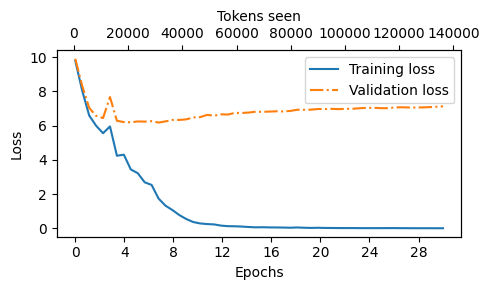

In [90]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3 Decoding strategies to control randomness

In [92]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




## 5.3.1 Temperature scaling

In [94]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [96]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [97]:
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [102]:
# torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [104]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [
        torch.multinomial(probas, num_samples=1).item() for i in range(1_000)
    ]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [105]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [108]:
temperatures = [1, 0.1, 5]

scaled_probas = [
    softmax_with_temperature(next_token_logits, T) for T in temperatures
]
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

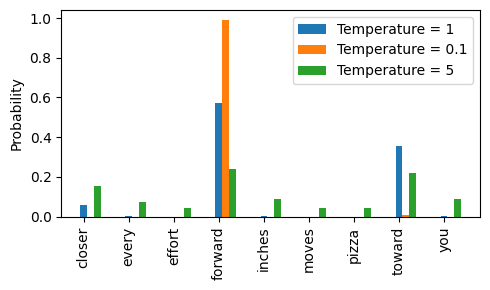

In [109]:
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
    bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

### 5.3.2 Top-k sampling

In [110]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [112]:
top_k = 3

top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [113]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [114]:
torch.softmax(new_logits, dim=0)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

### 5.3.3 Modifying the text generation function

In [115]:
tokenizer.decode([tokenizer.n_vocab - 1])

'<|endoftext|>'

In [124]:
def generate(
    model,
    idx, # (b, seq_len)
    max_new_tokens,
    context_size,
    temperature=0.0,
    top_k=None,
    eos_id=None
):    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            # (b, seq_len, vocab_size)
            logits = model(idx_cond)

        # (b, seq_len, vocab_size) -> (b, vocab_size)
        logits = logits[:, -1, :]

        if top_k is not None:
            # (b, k)
            top_logits, top_pos = torch.topk(logits, top_k)
            new_logits = torch.where(
                condition=logits < top_logits[:, -1],
                input=torch.tensor(float("-inf")),
                other=logits,
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # (b, 1)
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        # (b, seq_len + 1)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [126]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youenegger rendering GroundTemp aTweet laterbanks tilltorn redu portraitition added placed


## 5.4 Loading and saving model weights in PyTorch

In [128]:
torch.save(model.state_dict(), "model.pth")
# model.load_state_dict(torch.load("model.pth", map_location=device))

## 5.5 Loading pretrained weights from OpenAI

In [130]:
import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return True  # Indicate success without re-downloading

            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(download_url)
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                with open(destination, "wb") as file:
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except urllib.error.HTTPError:
                pass

        # If we reach here, both attempts have failed
        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Alternative way using `requests`
"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

2025-07-22 23:18:16.297041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 23:18:16.981807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753251497.215693    8425 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753251497.284930    8425 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753251497.873342    8425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [131]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 38.9kiB/s]
encoder.json: 100%|██████████████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 4.40MiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 40.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████████████████████████████████| 498M/498M [00:22<00:00, 21.9MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 2.37MiB/s]
model.ckpt.meta: 100%|█████████████████████████████████████████████████████████████████████| 471k/471k [00:00<00:00, 2.37MiB/s]
vocab.bpe: 100%|███████████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 2.23MiB/s]


In [132]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [133]:
type(params)

dict

In [134]:
params.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

In [137]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

GPT_CONFIG_124M = {
    "vocab_size": 50257,      # Vocabulary size
    "context_length": 1024,   # Context length
    "emb_dim": 768,           # Embedding dimension
    "n_heads": 12,            # Number of attention heads
    "n_layers": 12,           # Number of layers
    "drop_rate": 0.0,         # Dropout rate
    "qkv_bias": True          # Query-Key-Value bias
}

In [138]:
gpt2 = GPTModel(GPT_CONFIG_124M)
gpt2.eval();

In [139]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [141]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [143]:
load_weights_into_gpt(gpt2, params)
gpt2.to(device);

In [147]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt2,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as vision realizes. Vinenez (Shamal reply - Cas Doyle?, 235). In lEllander Class row
